In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 2

In [3]:
f(2)

6

In [4]:
x_rand = np.arange(-10,10,0.5)
y = f(x_rand)

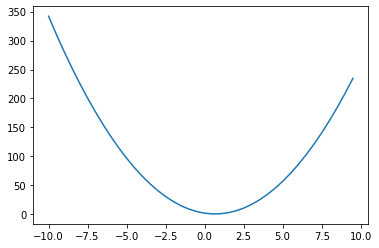

In [5]:
plt.plot(x_rand , y)

**Let's think**

- Now let's thing what is the derivative of this function at any point x?
- Check the defination of derivative, see what actually derivate tells us rather than just calculating it.

In [6]:
# Checking derivative

h = 0.000000001
x = 2.5
derivative = (f(x + h) - f(x))/h
derivative

11.000000910144081

## More than 2 inputs

In [7]:
h = 0.000001

#inputs

a = 2.0
b = 3.0
c = -1.5

# let's check d derivative w.r.t a
d1 = a * b + c
print('d1 : ', d1)
a += h
d2 = a * b + c
print('d2 : ', d2)

# let's check derivative now
print('slope : ', (d2 - d1)/h)

d1 :  4.5
d2 :  4.500003
slope :  3.000000000419334


In [8]:
# Let's do the same derivative check for b

# Checking the value of d without any change in b
print('d1 : ', d1)

# reversing the change that we did on a
a -= h

# doing some change in a
b += h

d3 = a * b + c
print('d3 : ',d3)

# let's check the derivative now

print('slope : ', (d3 - d1)/h)

d1 :  4.5
d3 :  4.500002
slope :  2.000000000279556


In [9]:
# Let's do the same derivative check for c

# Checking the value of d without any change in c
print('d1 : ', d1)

# reversing the change that we did on b
b -= h

# doing some change in c
c += h

d3 = a * b + c
print('d3 : ',d3)

# let's check the derivative now

print('slope : ', (d3 - d1)/h)

d1 :  4.5
d3 :  4.500001
slope :  1.000000000139778


## Value Object (Data Structure)

In [69]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op  # For operations
        self.label = label
        self.grad = 0.0
    
    # This repr function is very useful as if we will not use this value then we will
    # Get some kind of ugly ouput which is not understandable for end users
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Simply here we are just being precautious about other as if other is not of same 
        # instance of Value then we will make it one
        other = other if isinstance(other,Value) else Value(other)
        ans =  Value(self.data + other.data, (self, other) , '+')
        return ans
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        ans =  Value(self.data * other.data, (self, other), '*')
        return ans
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t , (self, ) , 'tanh')
        return out

## Manual Backpropagation of Simple Expression

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

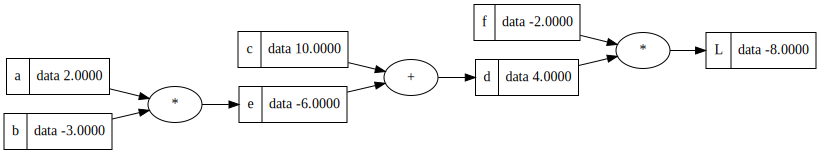

In [13]:
# Visualizing Forward Pass

draw_dot(L)

## Backward Pass

- As we know backward pass is mainly termed as Backpropagation.
- Backpropagation is simply derivative of final output with respect to it's leaf nodes
- Here with the term lead node I mean all those parameters which are not fixed from start. Some of the examples are Weights.

In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [15]:
L.grad = 1.0

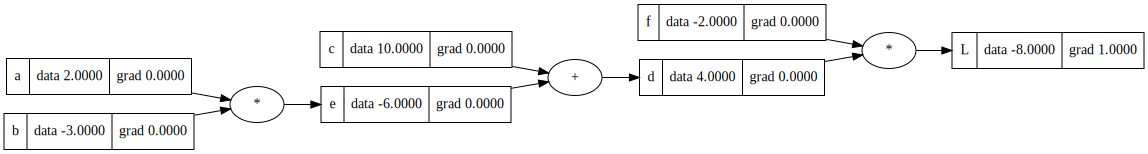

In [16]:
draw_dot(L)

In [17]:
def deriv():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L
    
    h = 0.00001
    
    # Derivative
    
    a = Value(2.0 , label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c;d.label = 'd'
    f = Value(-2.0, label='f')
    d.data += h
    L = d * f; L.label = 'L'
    L2 = L
    
    print((L2.data - L1.data)/h)
    
    
    
    

In [18]:
deriv()

-1.9999999999242843


In [19]:
d.grad = f.data
f.grad = d.data

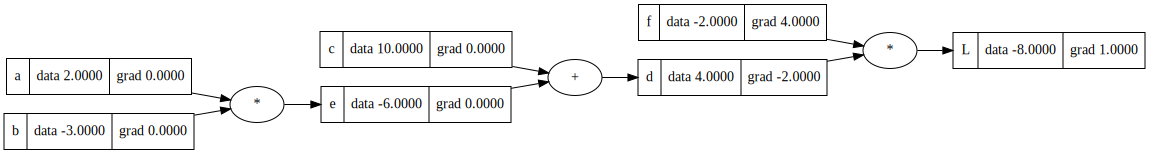

In [20]:
draw_dot(L)

**Here comes the most interesting part of Backpropagation**

$ dL/dc $

- As we knew that c node don't actually interact with final output L but indirectly it does ,as c affects d and d affects L

***Here we can use Chain Rule of Calculus***

- $ dL/dc = (dL/dd) * (dd/dc) $ 

- As knew $d = c + e$ 

So the $dd/dc = 1.0$

**In the end - **

$dl/dc = (f.data) * 1.0$

In [21]:
c.grad = f.data
e.grad = f.data # same as of c

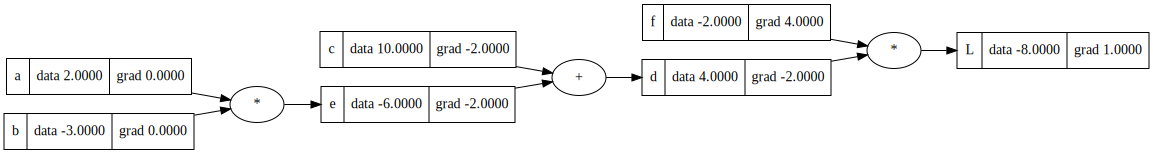

In [22]:
draw_dot(L)

- Now we will use that same chain rule of calculus here again 

* $ dL/db = dl/dd* dd/de * de/db $
* $e = a * b$

##### So with the help of calculus
* $de/db = a$

In [23]:
b.grad = (a.data) * (1.0) * (f.data)
a.grad = (b.data) * (1.0) * (f.data)

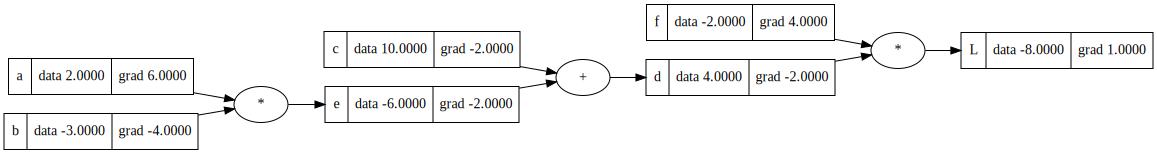

In [24]:
draw_dot(L)

In [25]:
# We can check our work with the help of deriv function whether we did correct or not

In [26]:
def deriv():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L
    
    h = 0.00001
    
    # Derivative
    
    a = Value(2.0 , label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c;d.label = 'd'
    f = Value(-2.0, label='f')
    d.data += h
    L = d * f; L.label = 'L'
    L2 = L
    
    print((L2.data - L1.data)/h)


In [27]:
deriv()

-1.9999999999242843


**This is what backpropagation is just a recursive application of chain rule backwards through the computation graph**

In [28]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


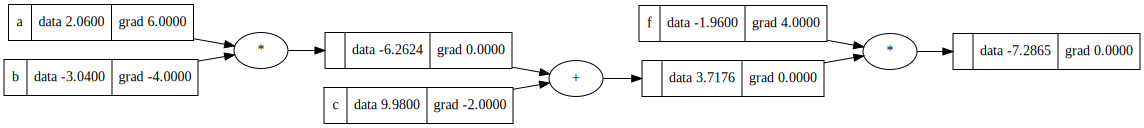

In [29]:
draw_dot(L)

## Manual Backpropagation of Neuron

### Tanh Function

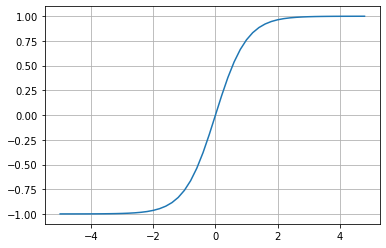

In [30]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5 , 5 , 0.2)))
plt.grid()

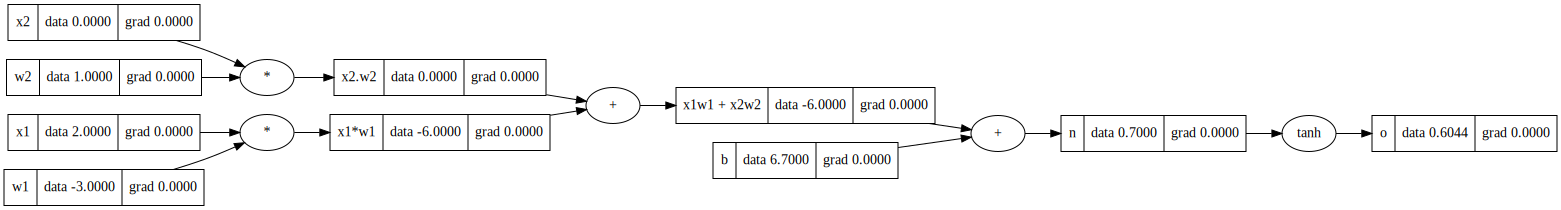

In [31]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

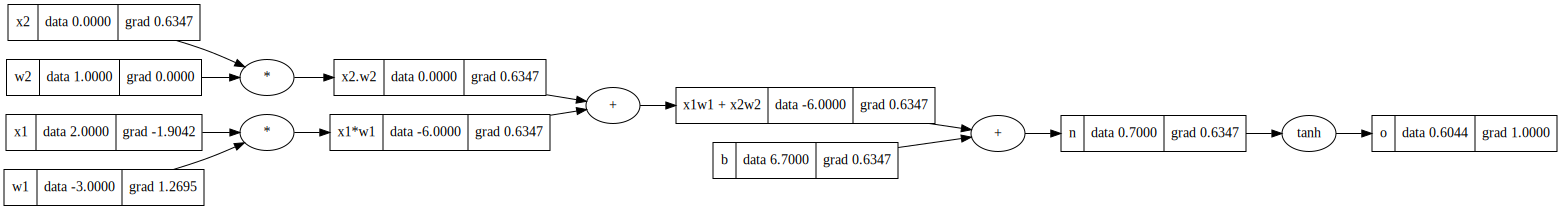

In [32]:
# Backpropagation

# base case, grad of o
o.grad = 1.0

# grad of n
# now we have to backpropagate by tanh ( do/dn )
# derivattive of tanh is 1 - tanh**2

n.grad = 1 - (o.data)**2


# for the derivate of x1w1x2w2 and b, we knew that + is just a distributor 
# of gradient, so simply the gradient of n will flow into both equally

x1w1x2w2.grad = n.grad * 1.0 # here 1.0 is grad of local derivative (simply by its own)
b.grad = n.grad * 1.0


# for grad of x1w1 and x2w2

x1w1.grad = 1.0 * x1w1x2w2.grad
x2w2.grad = 1.0 * x1w1x2w2.grad

# for grad of x1, w1, x2, w2
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

draw_dot(o)

## Implementing Backward Function For Each Operation

In [121]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op  # For operations
        self.label = label
        self.grad = 0.0
    
    # This repr function is very useful as if we will not use this value then we will
    # Get some kind of ugly ouput which is not understandable for end users
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other): # self + other
        other = other if isinstance(other,Value) else Value(other)
        ans =  Value(self.data + other.data, (self, other) , '+')
        def _backward():
            self.grad += 1.0 * ans.grad
            other.grad += 1.0 * ans.grad
            
        ans._backward = _backward
        return ans
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self , other): # self - other
        return self + (-other)
    
    def __mul__(self,other): # self * other
        other = other if isinstance(other,Value) else Value(other)
        ans =  Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * ans.grad
            other.grad += self.data * ans.grad
        ans._backward = _backward
        return ans
    
    def __pow__(self, other): # self**other
        assert isinstance(other , (int, float)), "only supporting int/float powers for now"
        
        out = Value(self.data ** other , (self ,) ,f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    # as with just __mul__ function we can't deal with 2 * a
    # with that we can only deal with a * 2
    # so we need __rmul__ which will check in 2 * a whether a knows or not
    # how to multiply a and 2.
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t , (self, ) , 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x) , (self , ) , 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
        
    # backpropagation function for whole expression in once
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)    
                topo.append(v)
        build_topo(self)
        
        # base case
        self.grad = 1.0
        # all other backward traversal
        for node in reversed(topo):
            node._backward()

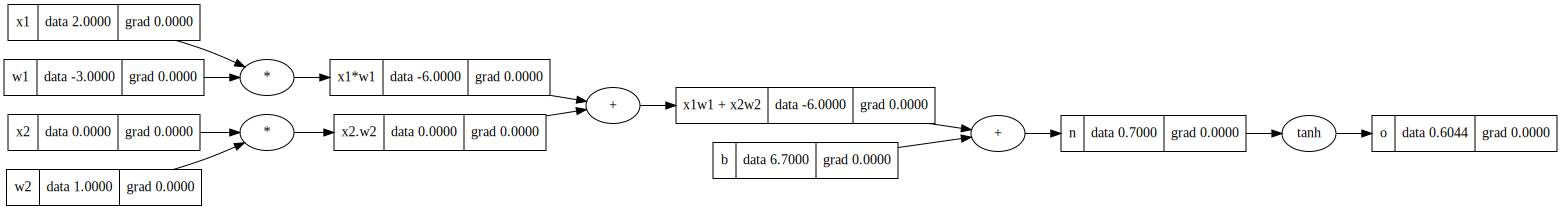

In [86]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

In [87]:
# base case
o.grad = 1.0

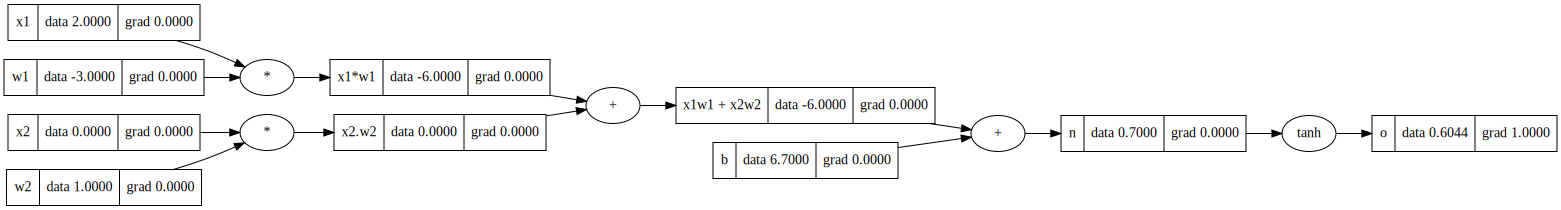

In [88]:
draw_dot(o)

In [89]:
o._backward()

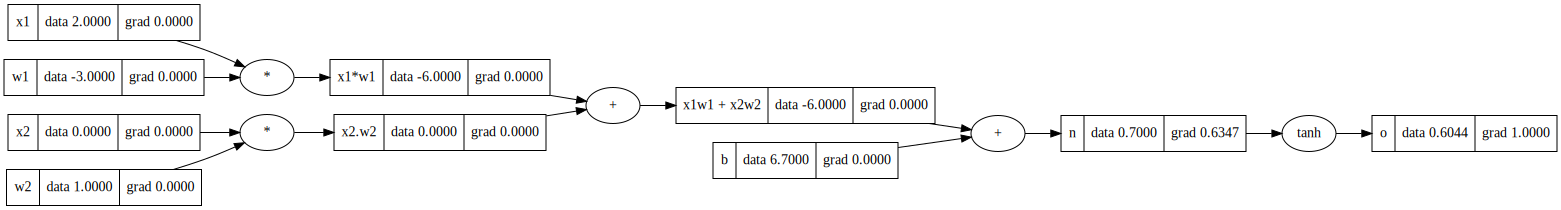

In [90]:
draw_dot(o)

In [91]:
n._backward()

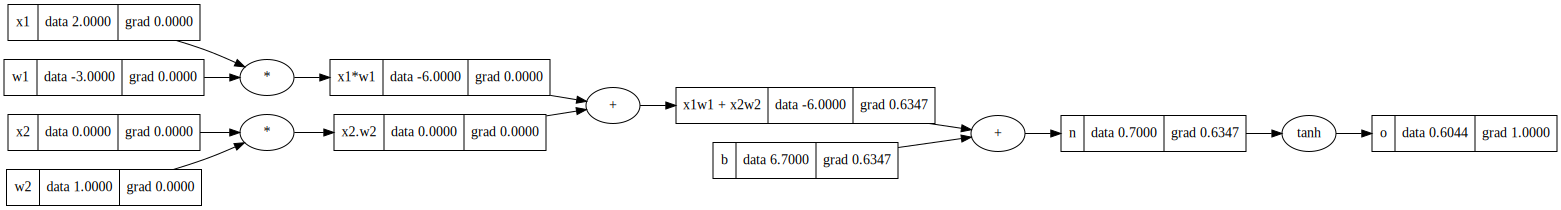

In [92]:
draw_dot(o)

In [93]:
b._backward()

In [94]:
x1w1x2w2._backward()

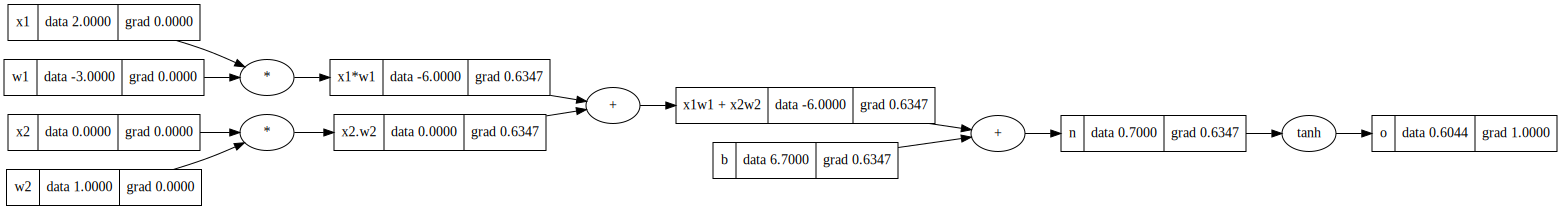

In [95]:
draw_dot(o)

In [96]:
x1w1._backward()
x2w2._backward()

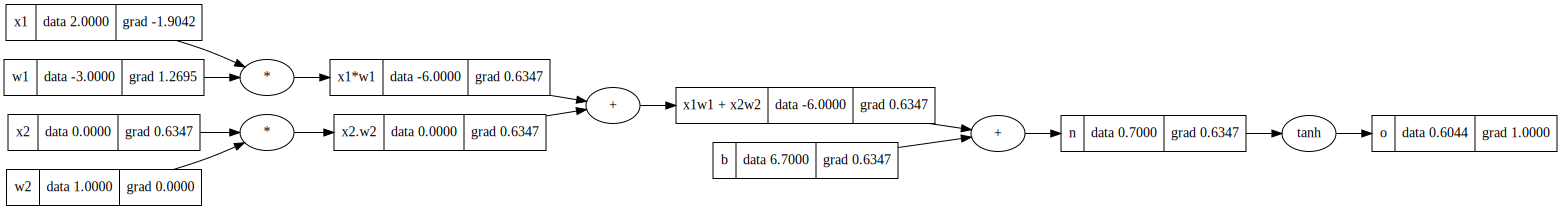

In [97]:
draw_dot(o)

- ***Simpy we just went backward from output till input taking derivative.***

## Implementing Backward Function For a Whole Expression

- We can move in one side using topological order

In [98]:
# let's make topological orders node list

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)    
        topo.append(v)
build_topo(o)
topo

[Value(data=6.7),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

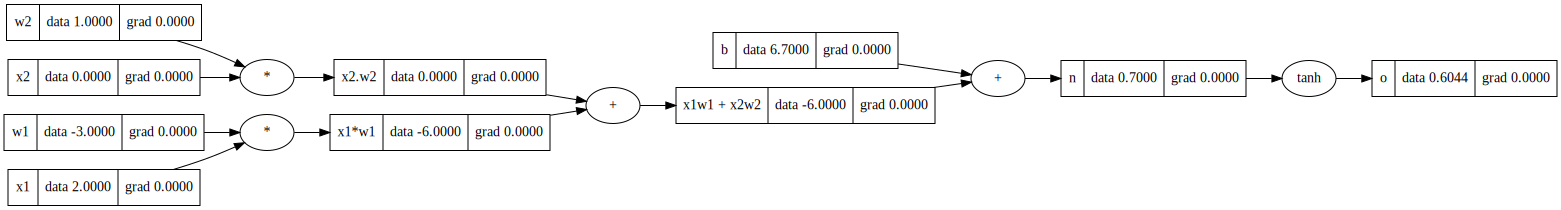

In [99]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

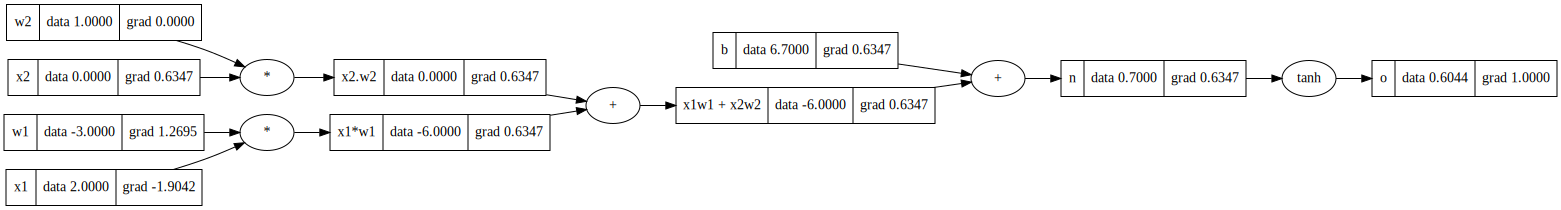

In [100]:
# Backward Pass

o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)    
        topo.append(v)
build_topo(o)


for node in reversed(topo):
    node._backward()

    
draw_dot(o)

In [101]:
o.backward()

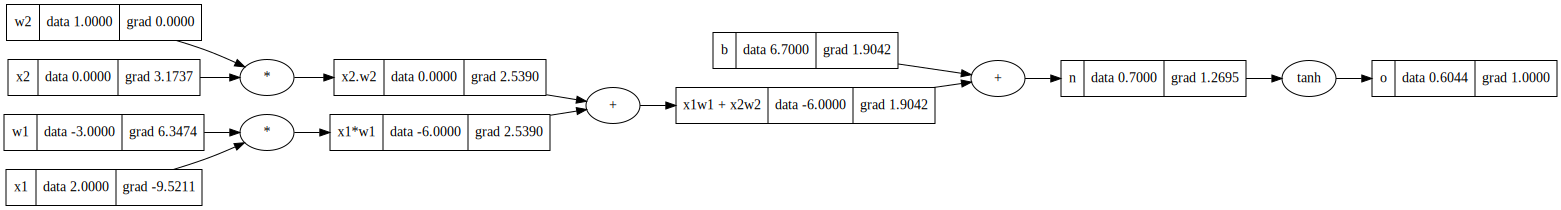

In [102]:
draw_dot(o)

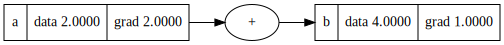

In [103]:
a = Value(2.0 , label = 'a')
b = a + a; b.label = 'b';
b.backward()
draw_dot(b)

- Instead of setting those gradients value we are accumulating them using  += signs this simply helps us as if we have a repetive nodes then it will have issue as the self and other grad will be of same node so same gradient will be done twice of the same node rather than adding them as for example $b = a + a$ in this equation $db/da$ will be equal to 2 but if we ill go with our same code in which we are just setting values then it will give 1 as an  output.

## Implementing tanh function by breaking it into pieces

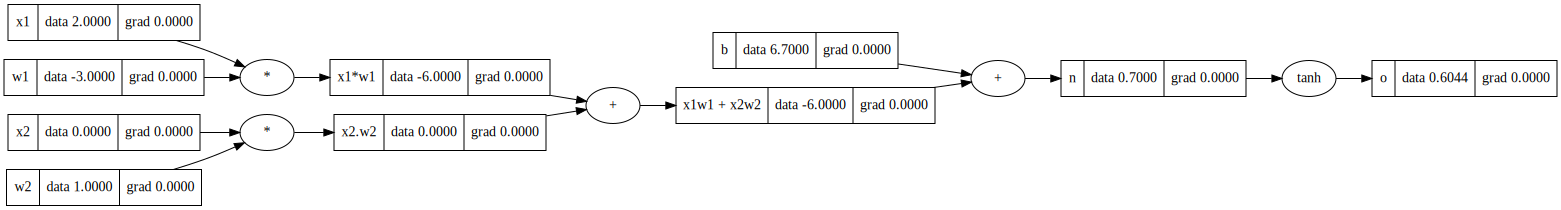

In [124]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

o = n.tanh(); o.label = 'o'

# checking graph

draw_dot(o)

In [127]:
o.backward()

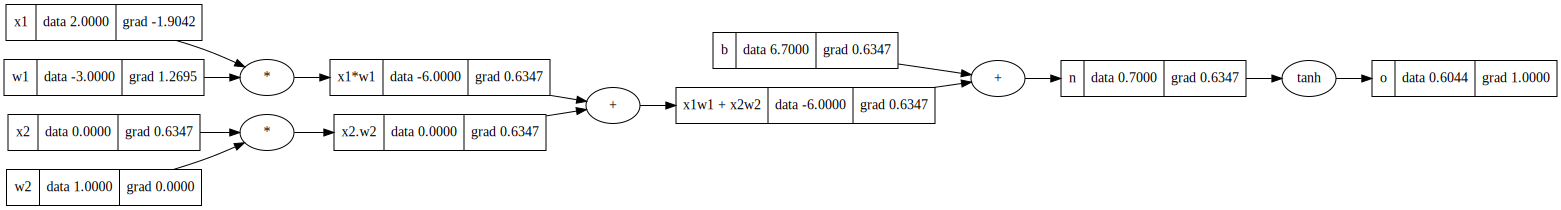

In [128]:
draw_dot(o)

**Previously we did without breaking tanh, now let's do it by that**

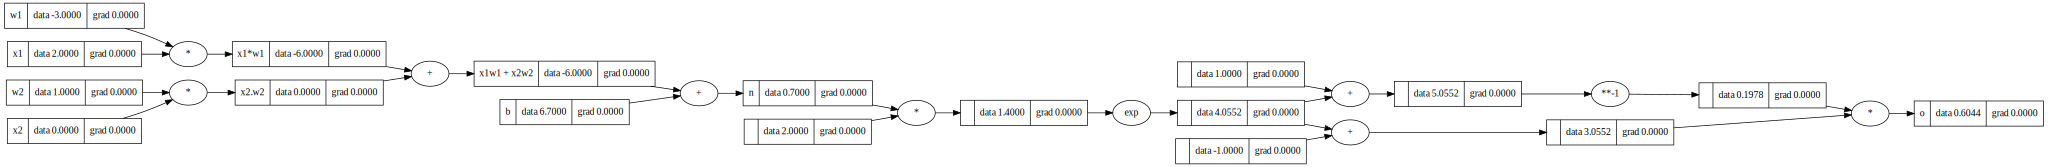

In [130]:
# Forward Pass

# inputs x1 , x2

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

# weights w1 , w2

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

# bias b of the neuron

b = Value(6.7 , label = 'b')


# below we are simply doing x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# passing our output through the activation function

# _____________________

e = (2 * n).exp()
o = (e - 1)/(e + 1)

#_____________________


o.label = 'o'

# checking graph

draw_dot(o)

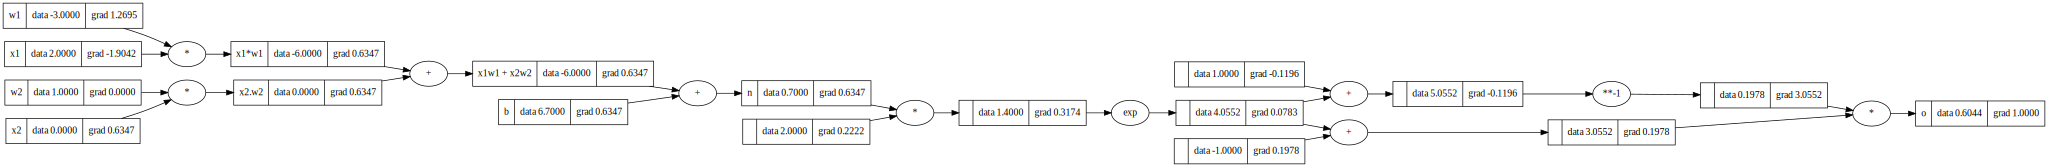

In [131]:
o.backward()
draw_dot(o)

- ***In simple words we have input and we perform functions over that input and we eventually get some output. If we will perform backpropagation then it does not matter what the function is and even we if we will use different function as many time possible from tiny function (as we breaked the tanh) till complex one like tanh we will get the same gradient all the time.***

# Performing all these works using PYTORCH

In [158]:
import torch


# here we are changing dtype to double as by default in python dtype is of float64/double but in pytorch tensor it is of float32
# so it's better to change it to double() to save ourselves from any other future issues

# by default pytorch assumes to not take gradient, that's why we are explicitly enabling it
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.881373587019]).double()      ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('o  : ' , o.data.item())
o.backward()


print('-------------------------')

print('x1 : ', x1.grad.item())
print('x2 : ', x2.grad.item())
print('w1 : ', w1.grad.item())
print('w2 : ', w2.grad.item())
print('b  : ', b.grad.item())

o  :  0.7071066904050358
-------------------------
x1 :  -1.5000003851533106
x2 :  0.5000001283844369
w1 :  1.0000002567688737
w2 :  0.0
b  :  0.5000001283844369
